In [14]:
import sys
import os
script_dir = os.getcwd() # coleata o diretorio do projeto atual
sys.path.append(script_dir)

In [22]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [17]:
class GeneticAlgorithm:
    def __init__(self, input_dim, output_dim, population_size, generations, dense_layers_range):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.population_size = population_size
        self.generations = generations
        self.dense_layers_range = dense_layers_range
        self.best_model = None
        self.best_accuracy = 0

    def create_mlp_model(self, input_dim, output_dim, dense_layers):
        model = models.Sequential()
        model.add(layers.Dense(dense_layers[0], input_dim=input_dim, activation='relu'))
        for neurons in dense_layers[1:]:
            model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dense(output_dim, activation='softmax'))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def create_population(self, size):
        population = []
        for _ in range(size):
            dense_layers = random.sample(self.dense_layers_range, random.randint(1, 3))
            individual = {"dense_layers": dense_layers}
            population.append(individual)
        return population

    def evaluate_individual(self, individual, X_train, y_train, X_test, y_test):
        model = self.create_mlp_model(self.input_dim, self.output_dim, individual["dense_layers"])
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        return accuracy, model

    def selection(self, population, fitnesses):
        sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
        return sorted_population[:self.population_size // 2]

    def crossover(self, parent1, parent2):
        child = {
            "dense_layers": random.choice([parent1["dense_layers"], parent2["dense_layers"]])
        }
        return child

    def mutation(self, individual):
        if random.random() < 0.1:  # 10% de chance de mutação
            individual["dense_layers"] = random.sample(self.dense_layers_range, random.randint(1, 3))

    def run(self, X_train, X_test, y_train, y_test):
        population = self.create_population(self.population_size)
        for generation in range(self.generations):
            fitnesses = []
            for ind in population:
                accuracy, model = self.evaluate_individual(ind, X_train, y_train, X_test, y_test)
                fitnesses.append(accuracy)
                if accuracy > self.best_accuracy:
                    self.best_accuracy = accuracy
                    self.best_model = model

            print(f'Generation {generation}, Best accuracy: {self.best_accuracy}')
            selected = self.selection(population, fitnesses)
            next_population = selected.copy()
            while len(next_population) < self.population_size:
                parent1, parent2 = random.sample(selected, 2)
                child = self.crossover(parent1, parent2)
                self.mutation(child)
                next_population.append(child)
            population = next_population

    def get_best_model(self):
        return self.best_model

    def plot_confusion_matrix(self, X_test, y_test):
        if self.best_model is None:
            raise ValueError("Best model has not been found. Run the genetic algorithm first.")

        # Fazer previsões com o melhor modelo
        y_pred = self.best_model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Gerar a matriz de confusão
        cm = confusion_matrix(y_true, y_pred_classes)

        # Plotar a matriz de confusão
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(self.output_dim))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()


c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 0, Best accuracy: 0.849056601524353
Generation 1, Best accuracy: 0.849056601524353
Generation 2, Best accuracy: 0.849056601524353
Generation 3, Best accuracy: 0.849056601524353
Generation 4, Best accuracy: 0.8616352081298828
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


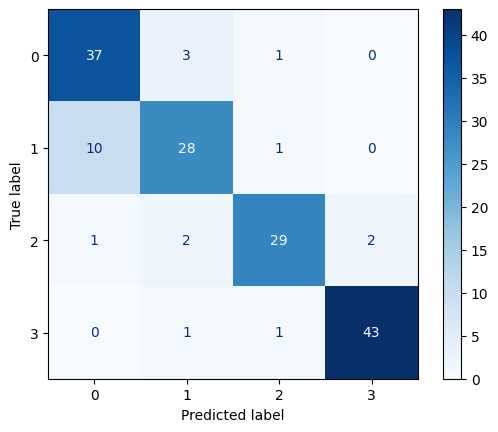

In [26]:
# Carregar e preparar dados
data = pd.read_csv(r'CSV\alternativas_separadas.csv')
data['Area_de_Conhecimento'] = data['Area_de_Conhecimento'].map({
    'Linguagens': 0,
    'Ciências Humanas': 1,
    'Ciências da Natureza': 2,
    'Matemática': 3
})

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    data['Enunciado'], data['Area_de_Conhecimento'], 
    test_size=0.2, random_state=1
)

# Vetorização dos textos usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

# Converter rótulos para one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Definir parâmetros para o algoritmo genético
input_dim = X_train.shape[1]  # Número de características após vetorização
output_dim = len(data['Area_de_Conhecimento'].unique())  # Número de classes
population_size = 10
generations = 5
dense_layers_range = [64, 32, 16, 8]

# Criar e executar o algoritmo genético
ga = GeneticAlgorithm(
    input_dim=input_dim, 
    output_dim=output_dim, 
    population_size=population_size, 
    generations=generations, 
    dense_layers_range=dense_layers_range
)
ga.run(X_train, X_test, y_train, y_test)

# Plotar a matriz de confusão do melhor modelo
ga.plot_confusion_matrix(X_test, y_test)